In [1]:
import collections
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import time
import json

from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Download remote zip file
def download_files(origin):
    cwd = os.path.abspath(".")
    fname = cwd + "/" + os.path.splitext(os.path.basename(origin))[0]+".zip"
    if not os.path.exists(fname):
        zip_file = tf.keras.utils.get_file(fname=fname, cache_subdir=cwd, origin=origin, extract=True)
        os.remove(zip_file)

# MS-COCO 2017 zip files from https://cocodataset.org/#download
annotations_zip = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
train_images_zip = "http://images.cocodataset.org/zips/train2017.zip"
# val_images_zip = "http://images.cocodataset.org/zips/val2017.zip"

# download_files(annotations_zip)
# download_files(train_images_zip)

In [4]:
annotation_file = os.path.abspath(".") + "/annotations/captions_train2017.json"
image_path = os.path.abspath(".") + "/train2017/"

with open(annotation_file, "r") as f:
    annotations = json.load(f)

data_dict = collections.defaultdict(list)
for image in annotations["annotations"]:
    caption = f"<start> {image['caption']} <end>"
    path = image_path + f"{image['image_id']:012d}.jpg"
    data_dict[path].append(caption)
    
data_x = []
data_y = []

for i, (path, captions) in enumerate(data_dict.items()):
    if i == 10000:
        break
    data_x.extend([path] * len(captions))
    data_y.extend(captions)
    
    
print("Length of data list:", len(data_dict))
print("Number of unique images:", len(set(data_x)))
print("Number of images (data_x):", len(data_x))
print("Number of captions (data_y):", len(data_y))
print("Average number of captions per image:", f"{len(data_x)/10000:0.4f}")

Length of data list: 118287
Number of unique images: 10000
Number of images (data_x): 50031
Number of captions (data_y): 50031
Average number of captions per image: 5.0031


In [5]:
words = []
for caption in data_y:
    ws = caption.split(" ")
    for word in ws:
        if word not in "?.,<>;':[]\{}|!@#$%^&*()" and word not in ["", "<start>", "<end>"]:
            words.append(word)

print("Number of unique words in captions:", len(set(words)))

Number of unique words in captions: 15393


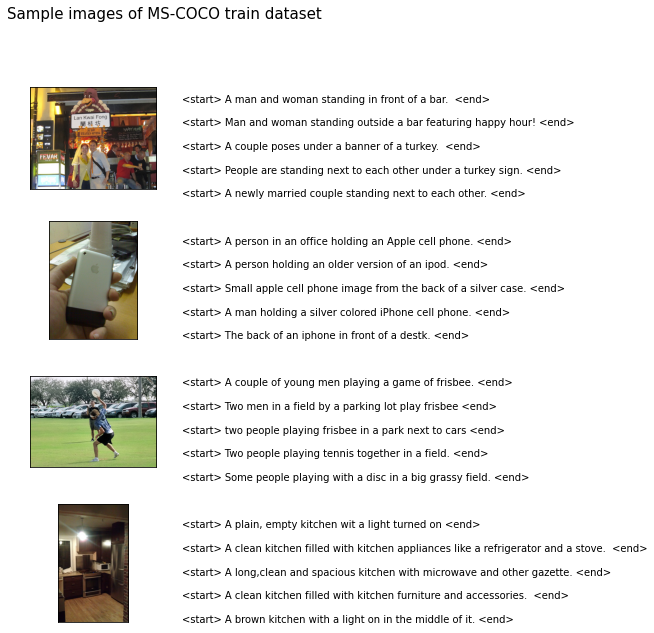

In [6]:
image_samples = np.random.randint(0, high=len(data_dict)-1, size=4)

fig = plt.figure(figsize=(5, 10))
for i, idx in enumerate(image_samples):
    img = list(data_dict.keys())[idx]
    captions = data_dict[img]
    
    axs = fig.add_subplot(4, 2, 2*i + 1, xticks=[], yticks=[])
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs.imshow(image)
    
    axs = fig.add_subplot(4, 2, 2*i + 2)
    plt.axis('off')
    axs.plot()
    axs.set_xlim(0, 1)
    axs.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        axs.text(0, i, caption, fontsize=10)
    
plt.suptitle("Sample images of MS-COCO train dataset", fontsize=15)
plt.show()

In [7]:
train_captions = data_y

def calc_max_length(tensor):
    return max(len(t) for t in tensor)


top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)
data_y = cap_vector

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2) 

print("x_train count:", len(x_train))
print("x_test count:", len(x_test))

x_train count: 40024
x_test count: 10007


In [9]:
batch_size = 128
train_shuffle_buffer_size = len(x_train)
test_shuffle_buffer_size = len(x_test)

def load_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, caption

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

test_data = test_data.shuffle(buffer_size=test_shuffle_buffer_size)
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data", train_data)
print("test_data", test_data)

train_data <PrefetchDataset shapes: ((None, 299, 299, 3), (None, 49)), types: (tf.float32, tf.int32)>
test_data <PrefetchDataset shapes: ((None, 299, 299, 3), (None, 49)), types: (tf.float32, tf.int32)>


In [10]:
def build_inception(image_height, image_width, num_channels):
    input_shape = [image_height, image_width, num_channels] # height, width, channels
    transfer_model_base = tf.keras.applications.inception_v3.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    transfer_model_base.trainable = True
    return transfer_model_base

In [11]:
base = build_inception(299, 299, 3)

In [12]:
BATCH_SIZE = 128
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(x_train) // BATCH_SIZE

In [13]:
class CNN(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = base(x)
        x = tf.reshape(x, (x.shape[0], -1))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [14]:
class RNN(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.W1 = tf.keras.layers.Dense(self.units)

    def call(self, x, features, hidden):
        x = self.embedding(x)
        x = tf.nn.tanh(x + tf.expand_dims(features, 1))
        output, state = self.gru(x, hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [15]:
encoder = CNN(embedding_dim)
decoder = RNN(embedding_dim, units, vocab_size)

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [17]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
                predictions, hidden = decoder(dec_input, features, hidden)
                loss += loss_function(target[:, i], predictions)
                dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [18]:
from tqdm import tqdm

EPOCHS = 10

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(tqdm(train_data)):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
    loss_plot.append(total_loss / num_steps)
    
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|▍                                                                                                                                             | 1/313 [00:51<4:25:31, 51.06s/it]

Epoch 1 Batch 0 Loss 1.9706


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [01:19<01:01,  3.43it/s]

Epoch 1 Batch 100 Loss 1.0354


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [01:47<00:34,  3.28it/s]

Epoch 1 Batch 200 Loss 0.9486


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [02:15<00:03,  3.44it/s]

Epoch 1 Batch 300 Loss 0.8453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch 1 Loss 1.004125
Time taken for 1 epoch 168.24 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:57,  2.65it/s]

Epoch 2 Batch 0 Loss 0.8513


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:29<01:02,  3.37it/s]

Epoch 2 Batch 100 Loss 0.7772


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:57<00:33,  3.39it/s]

Epoch 2 Batch 200 Loss 0.7432


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:25<00:03,  3.45it/s]

Epoch 2 Batch 300 Loss 0.7211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.53it/s]


Epoch 2 Loss 0.801848
Time taken for 1 epoch 88.59 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:58,  2.62it/s]

Epoch 3 Batch 0 Loss 0.7276


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:28<01:02,  3.40it/s]

Epoch 3 Batch 100 Loss 0.6938


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:56<00:32,  3.43it/s]

Epoch 3 Batch 200 Loss 0.7140


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:24<00:03,  3.44it/s]

Epoch 3 Batch 300 Loss 0.7882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.55it/s]


Epoch 3 Loss 0.733944
Time taken for 1 epoch 88.23 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:57,  2.66it/s]

Epoch 4 Batch 0 Loss 0.7094


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:29<01:05,  3.24it/s]

Epoch 4 Batch 100 Loss 0.7235


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:57<00:32,  3.48it/s]

Epoch 4 Batch 200 Loss 0.7482


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:25<00:03,  3.42it/s]

Epoch 4 Batch 300 Loss 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.52it/s]


Epoch 4 Loss 0.694991
Time taken for 1 epoch 88.88 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<02:10,  2.38it/s]

Epoch 5 Batch 0 Loss 0.6609


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:30<01:02,  3.42it/s]

Epoch 5 Batch 100 Loss 0.6424


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:58<00:33,  3.39it/s]

Epoch 5 Batch 200 Loss 0.6870


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:26<00:03,  3.40it/s]

Epoch 5 Batch 300 Loss 0.6962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:29<00:00,  3.48it/s]


Epoch 5 Loss 0.665106
Time taken for 1 epoch 90.02 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<02:16,  2.29it/s]

Epoch 6 Batch 0 Loss 0.6459


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:28<01:01,  3.43it/s]

Epoch 6 Batch 100 Loss 0.6174


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:56<00:32,  3.44it/s]

Epoch 6 Batch 200 Loss 0.6065


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:25<00:03,  3.46it/s]

Epoch 6 Batch 300 Loss 0.6629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.54it/s]


Epoch 6 Loss 0.641267
Time taken for 1 epoch 88.41 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:57,  2.66it/s]

Epoch 7 Batch 0 Loss 0.5796


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:28<01:02,  3.38it/s]

Epoch 7 Batch 100 Loss 0.6338


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:56<00:32,  3.45it/s]

Epoch 7 Batch 200 Loss 0.6329


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:25<00:03,  3.43it/s]

Epoch 7 Batch 300 Loss 0.6347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.53it/s]


Epoch 7 Loss 0.620723
Time taken for 1 epoch 88.62 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:58,  2.64it/s]

Epoch 8 Batch 0 Loss 0.5604


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:28<01:02,  3.40it/s]

Epoch 8 Batch 100 Loss 0.6193


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:58<00:34,  3.24it/s]

Epoch 8 Batch 200 Loss 0.5740


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:27<00:03,  3.45it/s]

Epoch 8 Batch 300 Loss 0.5832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:31<00:00,  3.44it/s]


Epoch 8 Loss 0.604626
Time taken for 1 epoch 91.03 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<02:00,  2.59it/s]

Epoch 9 Batch 0 Loss 0.5927


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:29<01:02,  3.40it/s]

Epoch 9 Batch 100 Loss 0.5558


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:58<00:32,  3.43it/s]

Epoch 9 Batch 200 Loss 0.5885


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:26<00:03,  3.42it/s]

Epoch 9 Batch 300 Loss 0.5964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:29<00:00,  3.49it/s]


Epoch 9 Loss 0.585728
Time taken for 1 epoch 89.68 sec



  0%|▍                                                                                                                                               | 1/313 [00:00<01:58,  2.63it/s]

Epoch 10 Batch 0 Loss 0.5257


 32%|█████████████████████████████████████████████▊                                                                                                | 101/313 [00:28<01:01,  3.42it/s]

Epoch 10 Batch 100 Loss 0.5500


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 201/313 [00:57<00:32,  3.46it/s]

Epoch 10 Batch 200 Loss 0.5987


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 301/313 [01:25<00:03,  3.45it/s]

Epoch 10 Batch 300 Loss 0.5646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.53it/s]

Epoch 10 Loss 0.568558
Time taken for 1 epoch 88.71 sec



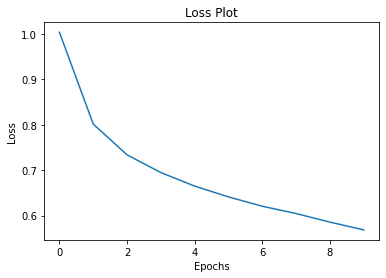

In [19]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Caption: <start> a white sink that has a necklace a rubber <unk> toothpaste and some beauty items laying around them <end>
Prediction Caption: a bathroom with a sink and a sink <end>


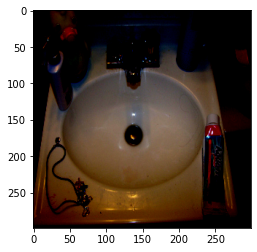

In [24]:
def evaluate(image, caption):
    temp_input = load_image(image, caption)[0]
    image = tf.expand_dims(temp_input, axis=0)
    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    hidden = decoder.reset_state(batch_size=1)

    for i in range(max_length):
        predictions, hidden = decoder(dec_input, features, hidden)
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result

rid = np.random.randint(0, len(x_train))
image = x_train[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in y_train[rid] if i not in [0]])

result = evaluate(image, real_caption)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plt.imshow(load_image(image, caption)[0])

In [25]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

ckpt_manager.save()

'./checkpoints/train\\ckpt-1'